In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akkusjain11","key":"11c1af67dc138ec4df9105153a0c065d"}'}

In [ ]:
import os
import zipfile

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permission

# Download the dataset
!kaggle datasets download -d emmarex/plantdisease

# Unzip the dataset
with zipfile.ZipFile("plantdisease.zip", "r") as zip_ref:
    zip_ref.extractall("PlantVillage")

# Check extracted files
os.listdir("PlantVillage")


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 650M/658M [00:04<00:00, 131MB/s]
100% 658M/658M [00:04<00:00, 161MB/s]


['PlantVillage', 'plantvillage']

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
import psutil



In [ ]:
# Set paths
dataset_path = "PlantVillage/PlantVillage"
train_dir = "train"
val_dir = "val"
test_dir = "test"

# Remove existing folders (if any)
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(val_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)

# Split dataset (80% train, 10% validation, 10% test)
for category in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, category)
    images = os.listdir(img_path)
    np.random.shuffle(images)

    train_split = int(0.8 * len(images))
    val_split = int(0.9 * len(images))

    # Create folders
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Move images
    for i, img in enumerate(images):
        src = os.path.join(img_path, img)
        if i < train_split:
            dest = os.path.join(train_dir, category, img)
        elif i < val_split:
            dest = os.path.join(val_dir, category, img)
        else:
            dest = os.path.join(test_dir, category, img)
        shutil.copy(src, dest)

# Image sizes
IMG_SIZE = 224
BATCH_SIZE = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

num_classes = len(train_generator.class_indices)


Found 16504 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.
Found 2070 images belonging to 15 classes.


In [ ]:
def coatnet_block(x, filters):
    x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    return x

def build_coatnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CoatNet-like structure: CNN + Transformer Hybrid
    x = coatnet_block(inputs, 64)
    x = coatnet_block(x, 128)
    x = coatnet_block(x, 256)

    # Global Average Pooling & Fully Connected Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, x)
    return model

# Build the CoatNet model
model = build_coatnet((IMG_SIZE, IMG_SIZE, 3), num_classes)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,288,271 (4.91 MB)

 Trainable params: 1,286,479 (4.91 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
EPOCHS = 10

start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)
end_time = time.time()

# Training Time
training_time = end_time - start_time


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 327s 572ms/step - accuracy: 0.5582 - loss: 1.4202 - val_accuracy: 0.2839 - val_loss: 3.3410
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 324s 513ms/step - accuracy: 0.7848 - loss: 0.6823 - val_accuracy: 0.6948 - val_loss: 0.9542
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 265s 513ms/step - accuracy: 0.8363 - loss: 0.5079 - val_accuracy: 0.7185 - val_loss: 1.0638
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 265s 513ms/step - accuracy: 0.8714 - loss: 0.3983 - val_accuracy: 0.7437 - val_loss: 0.9065
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 264s 512ms/step - accuracy: 0.8990 - loss: 0.3234 - val_accuracy: 0.7742 - val_loss: 0.7638
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 255s 495ms/step - accuracy: 0.9093 - loss: 0.2744 - val_accuracy: 0.8086 - val_loss: 0.6457
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 263s 496ms/step - accuracy: 0.9253 - loss: 0.2325 - val_accuracy: 0.7922 - val_loss: 0.9150
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 257s 498ms/step - accuracy: 0.9329 -

65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.8443 - loss: 0.5096


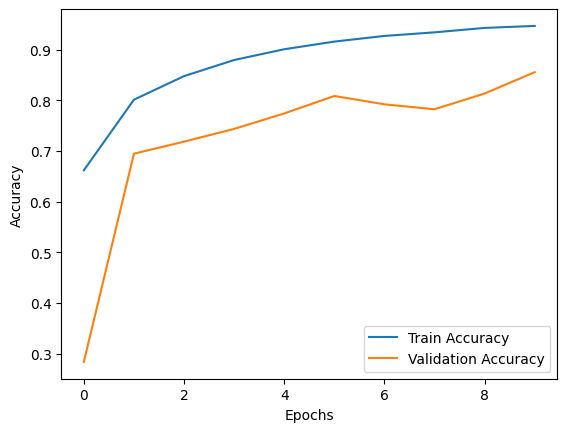

In [ ]:
# Evaluate test accuracy
test_loss, test_accuracy = model.evaluate(test_generator)

# Plot accuracy/loss curves
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
# Calculate Model Size
model_size = sum([np.prod(v.shape) for v in model.trainable_variables])
model_size_MB = model_size * 4 / (1024 ** 2)  # Convert to MB

# Print Summary
print(f"Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Model Size: {model_size_MB:.2f} MB")


Training Accuracy: 94.69%
Validation Accuracy: 85.56%
Test Accuracy: 85.31%
Training Time: 2729.39 seconds
Model Size: 4.91 MB


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.04      0.05      0.05       100
                     Pepper__bell___healthy       0.09      0.14      0.10       148
                      Potato___Early_blight       0.07      0.08      0.07       100
                       Potato___Late_blight       0.08      0.08      0.08       100
                           Potato___healthy       0.00      0.00      0.00        16
                      Tomato_Bacterial_spot       0.07      0.06      0.06       213
                        Tomato_Early_blight       0.09      0.11      0.10       100
                         Tomato_Late_blight       0.11      0.12      0.11       191
                           Tomato_Leaf_Mold       0.03      0.02      0.03        96
                  Tomato_Septoria_leaf_spot       0.06      0.06      0.06       178
T

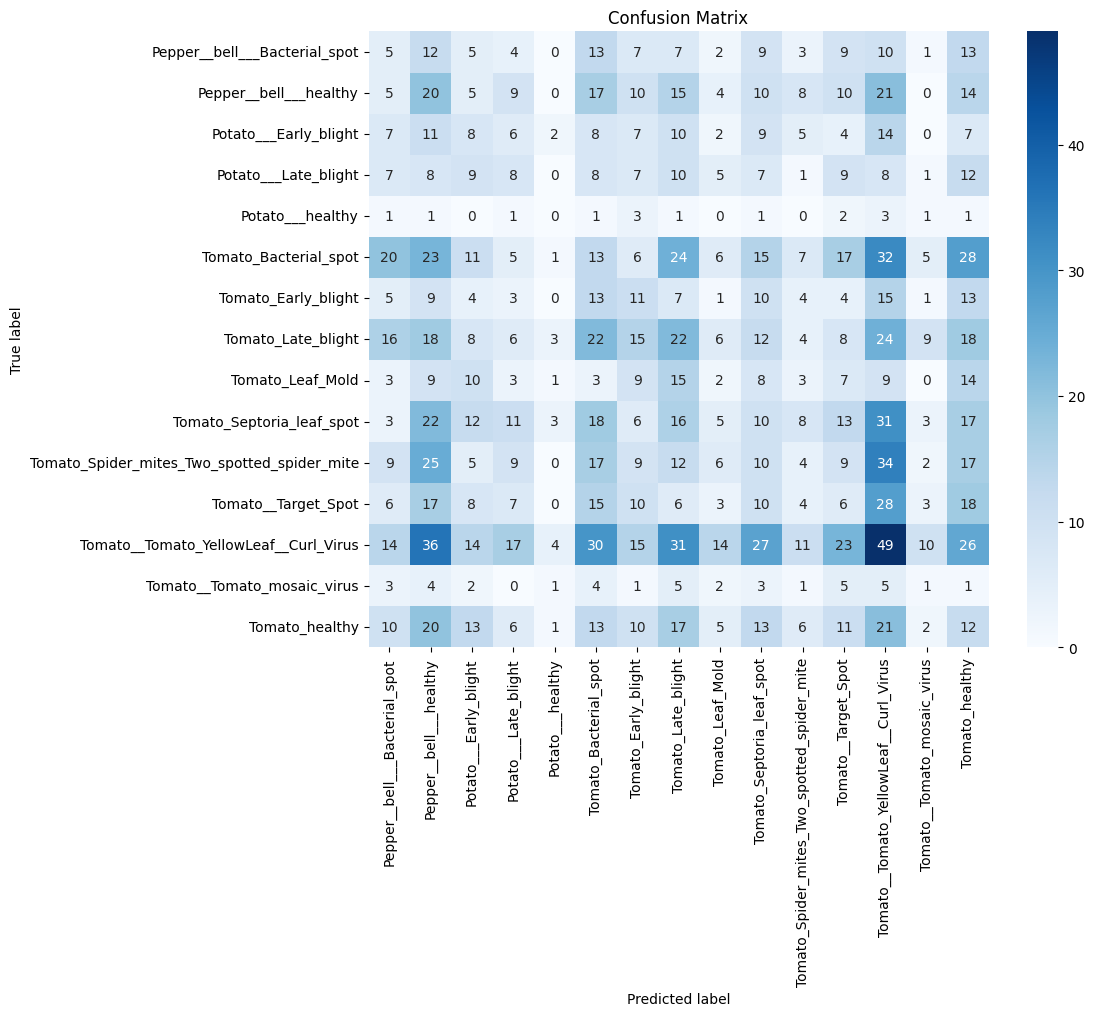

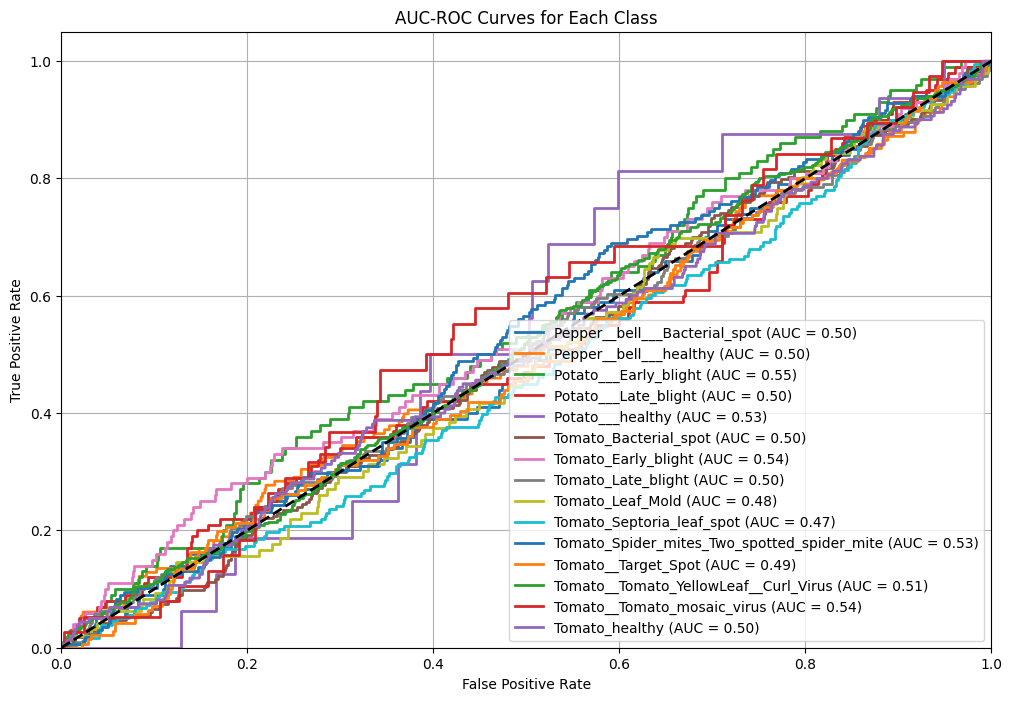

Macro-average AUC (OvR): 0.5083
Weighted-average AUC (OvR): 0.5043


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import itertools

# Generate predictions and true labels
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# One-hot encode the true labels for multi-class AUC calculation
y_true_binarized = label_binarize(y_true, classes=range(len(class_labels)))

# 1️⃣ Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 2️⃣ Enhanced Confusion Matrix Visualization with Heatmap
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap='Blues'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

cm = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, class_labels, title='Confusion Matrix')

# 3️⃣ AUC-ROC Curves for each class (One-vs-Rest strategy)
plt.figure(figsize=(12, 8))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 4️⃣ Macro and Weighted AUC using OvR strategy
print(f"Macro-average AUC (OvR): {roc_auc_score(y_true_binarized, y_pred, average='macro'):.4f}")
print(f"Weighted-average AUC (OvR): {roc_auc_score(y_true_binarized, y_pred, average='weighted'):.4f}")
